### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.formula.api as smf
import seaborn as sns

from wordcloud import WordCloud

from src.data.some_dataloader import *
from article_to_country import *
from plots import *

# <span style="color:#9689d6">ADA - Class Project</span>

## Team: Les Fraises TagADA
    Petit-Phar Oriane
    Friedrich Claire
    Gotti Bryan
    Théo Schifferli
    Jérémy Barghorn

# Table of contents : 

- [1. Are there cultural biases intrinsic to the Wikipedia graph?](#1-are-there-cultural-biases-intrinsic-to-the-wikipedia-graph)
    - [1.1 What countries are the most present in the Wikipedia graph](#11-what-countries-are-the-most-present-in-the-wikipedia-graph)
    - [1.2 Are articles about some countries on average more connected than others](#12-are-articles-about-some-countries-on-average-more-connected-than-others)
- [2. Are there cultural biases in the way players play Wikispeedia?](#2-are-there-cultural-biases-in-the-way-players-play-wikispeedia)
    - [2.1 What articles are most often clicked on? How does this relate to the country of the article?](#21-what-articles-are-most-often-clicked-on-how-does-this-relate-to-the-country-of-the-article)
    - [2.2 What paths do Wikispeedia players most follow? Are there "highway paths" that are very often used? Can this be linked to a cultural bias?](#22-what-paths-do-wikispeedia-players-most-follow-are-there-highway-paths-that-are-very-often-used-can-this-be-linked-to-a-cultural-bias)
    - [2.3 What articles are most likely to cause a player to stop the game? What makes those articles "dead ends"? What does this have to do with the country of these articles?](#23-what-articles-are-most-likely-to-cause-a-player-to-stop-the-game-what-makes-those-articles-dead-ends-what-does-this-have-to-do-with-the-country-of-these-articles)
- [3. How can we explain the players' biases?](#3-how-can-we-explain-the-players-biases)
    - [3.1 Does it simply derive from the fact that the Wikipedia graph is already biased in itself?](#31-does-it-simply-derive-from-the-fact-that-the-wikipedia-graph-is-already-biased-in-itself)
    - [3.2 What is the distribution of countries among start / target articles for the Wikispeedia games? If it is not balanced, could this be an explanation?](#32-what-is-the-distribution-of-countries-among-start--target-articles-for-the-wikispeedia-games-if-it-is-not-balanced-could-this-be-an-explanation)
    - [3.3 Is there something inherent to the way players play the game?](#33-is-there-something-inherent-to-the-way-players-play-the-game)


# 1. Are there cultural biases intrinsic to the Wikipedia graph?


## 1.1 What countries are the most present in the Wikipedia graph

First a naive approach is used by doing a text search and finding all the country string names inside the plaintext. This is done with help of a regex that matches all the countries in all the files. The results are then parsed in a table containing as index the article name and as columns all the possible countries on earth along with the number of occurences in the specific article. The following cell is doing this and should take arround 4min to run.

In [25]:
country_data = country_occurences_in_files()
counts = filter_top_k(country_data, k=2, N=1)

4604it [11:34,  6.63it/s]


This table is then used in order to find the top K countries inside an article with at least N occurences

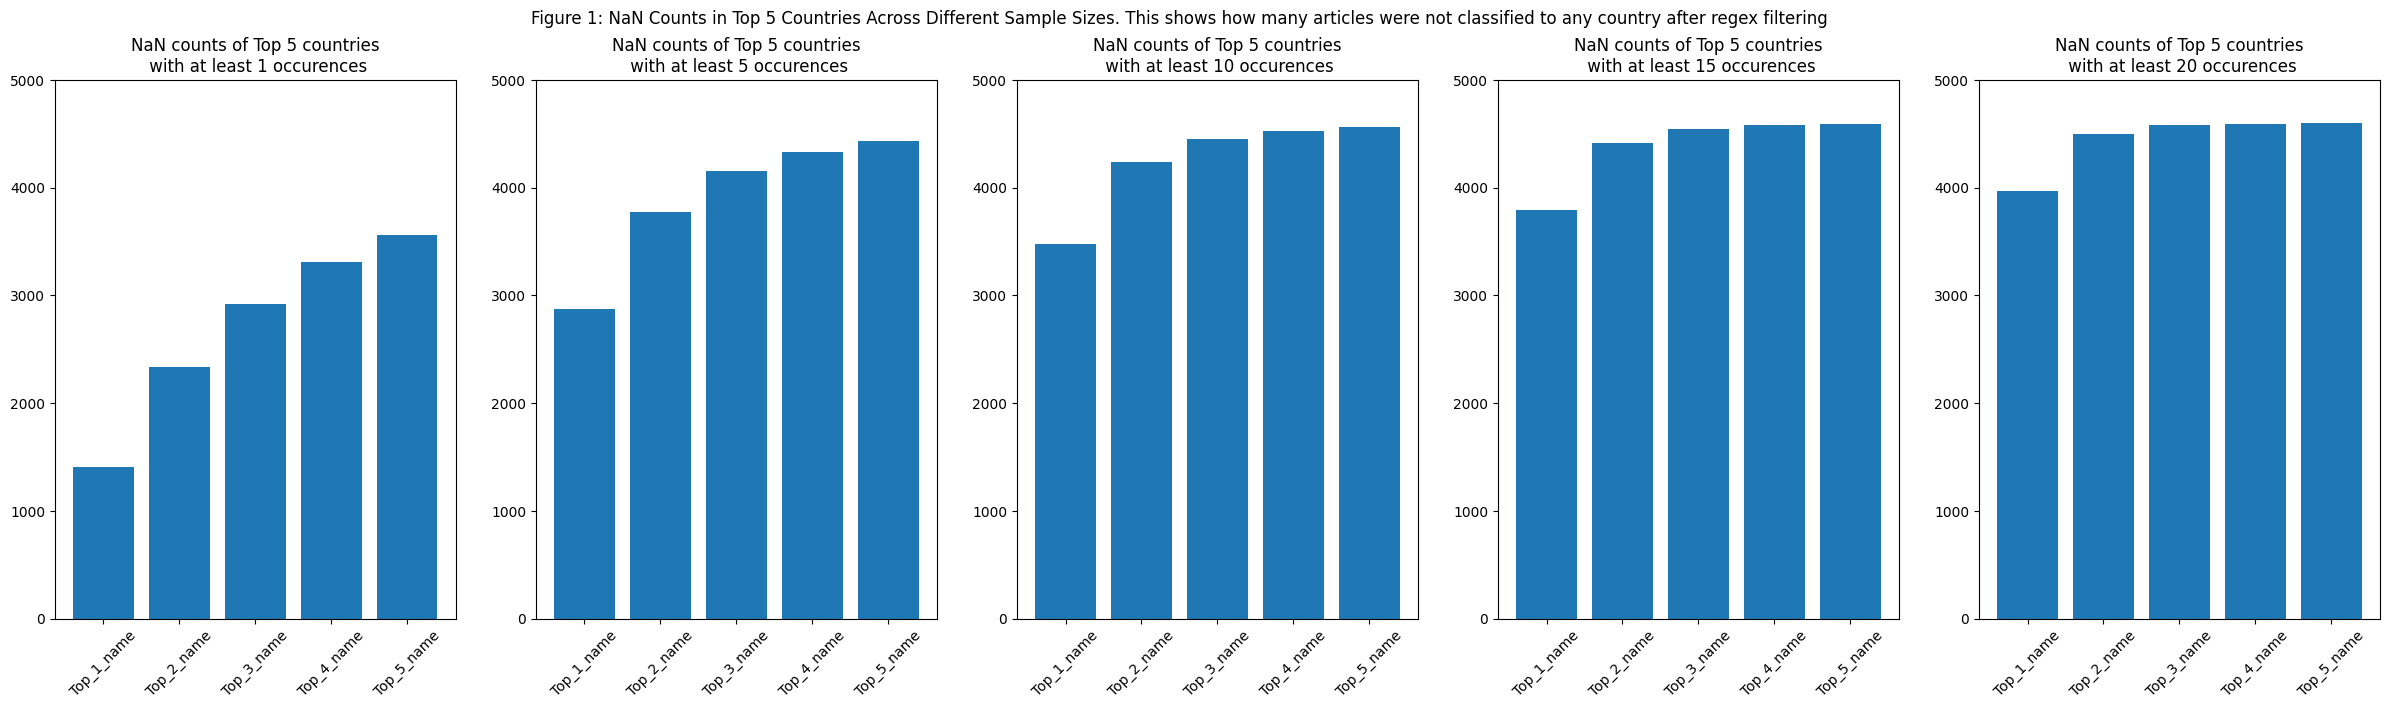

In [26]:
N_samples = [1, 5, 10, 15, 20]
K = 5

fig, axs = plt.subplots(1, len(N_samples), figsize=(30, 7))

i = 0
for j, N in enumerate(N_samples):
    counts = filter_top_k(country_data, k=K, N=N)
    df_cleaned = counts.iloc[:, :K]
    df_stat = df_cleaned.isna().sum()
    axs[j].bar(df_stat.index, df_stat)
    axs[j].set_title(f"NaN counts of Top {K} countries\n with at least {N} occurences")
    axs[j].set_ylim(0, 5000)
    axs[j].xaxis.set_tick_params(rotation=45)
fig.suptitle("Figure 1: NaN Counts in Top 5 Countries Across Different Sample Sizes. This shows how many articles were not classified to any country after regex filtering")
plt.show()

From the previous cell it was clear that in order to classify the maximum number of articles we needed to pick a small number of occurences (N = 1) in order to avoid discarding more than half of the articles. 

In [27]:
counts = filter_top_k(country_data, k=2, N=1)
nan_df = counts[counts.isna().all(axis=1)]
print(f"Number of articles with no countries before completion with llama: {len(nan_df)}")


Number of articles with no countries before completion with llama: 1412


This approach resulted in 1412 articles having no country assigned to them. By going manually through them it can be seen that as a human some articles can be further classified to countries even if the country name is not explicetly mentionned in the text.

For example, the article 4-2-0 is about a railway in the United States, in Chicago, but does not contain the substring "United States". Yet, it can clearly be associated to a country (USA) and this is what the LLM successfully achieved. 

### Further classifying articles to countires with the help of small llm's

Two LLM's were tested (Qwen and Llama) and only Llama (a Meta LLM) was retained in order to assign the missing articles to countries. For this to be done the LLM was downloaded locally and used for inference on the plaintext articles. 

The format of the prompt used to let the model classify articles to countries was : 
```
<system_prompt_begin>
You will be given textual articles. For each article provide single and unique country to which the article is related and should be classified to. Provide the answer in the form : <country>. If there is no country related to the article, please write 'None'. If the location is not on earth, please write 'None'. You must be 100\% sure this is a question of life or death.
<system_prompt_end>

<user_prompt_begin>
plaintext article
<user_prompt_end>
```

Run this by executing the following cell : 
(Note : It was already preprocessed so this can also be skipped and the  ```data/country_occurences.csv``` can be loaded)

In [28]:
# !python article_to_country.py

In [29]:
refined_data = pd.read_csv("data/country_occurences.csv", index_col=0)
nan_df = refined_data[refined_data.isna().all(axis=1)]
print(f"Number of articles with no countries after completion with llama: {len(nan_df)}")

Number of articles with no countries after completion with llama: 887


This approach allowed to classify 1412 - 887 = 525 new articles having a country assigned to them. In the cell below it can be seen which articles were classified with help of the LLM (the ones having a "Top_1_count" of 0 meaning 0 occurences of this exact substring in the text but still classified as this country by the llm because it was able to extract a country based on the abstract content of the article)

In [30]:
refined_data[refined_data["Top_1_count"] == 0].head(10)

,Top_1_name,Top_2_name,Top_1_count,Top_2_count
1980_eruption_of_Mount_St._Helens,united states,NaN,0.0,NaN
4-2-0,united states,NaN,0.0,NaN
4-4-0,united states,NaN,0.0,NaN
4-6-0,united states,NaN,0.0,NaN
4th_century,india,NaN,0.0,NaN
6-2-0,united states,NaN,0.0,NaN
8th_century,united kingdom,NaN,0.0,NaN
Aardvark,south africa,NaN,0.0,NaN
Abbadid,spain,NaN,0.0,NaN
Abstract_art,russia,NaN,0.0,NaN


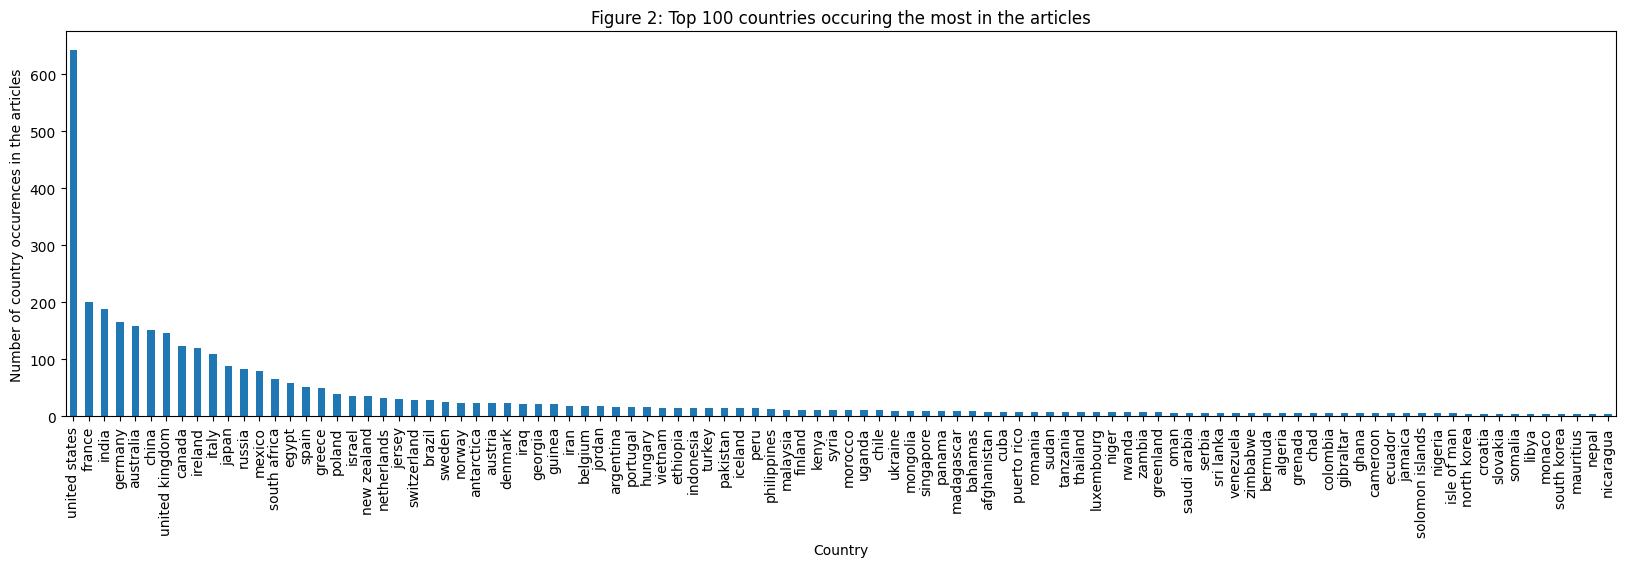

In [31]:
refined_data.groupby("Top_1_name").size().sort_values(ascending=False).head(100).plot(kind="bar", figsize=(20, 5))

plt.ylabel("Number of country occurences in the articles")
plt.xlabel("Country")

plt.title("Figure 2: Top 100 countries occuring the most in the articles")
plt.show()

On the plot above, we can note that the country that is the most represented in the Wikipedia graph is with no suprise the United States. It occures 3 times more than the second most occurring country (France) which is a very large lead. This is the first evidence showing that the Wikipedia data is biased towards USA data and this observation will have to be taken into account when doing further analyses. A second observation that we can make on this plot is that the distribution of country occurrences is skewed towrads the right, meaning that most countries do not occur often and few occur often. There are around 10 "country leadres" in the Wikipedia graph (USA, France, India, Germany, AUstralia, China, UK, Canada, Ireland, Italy, Japan, Russia). These "leaders" coincide with the countries leading the real world. This shows that Wikipedia contains more articles on topics ratached to countries with real-world influence than to smaller, less influencing countries. 

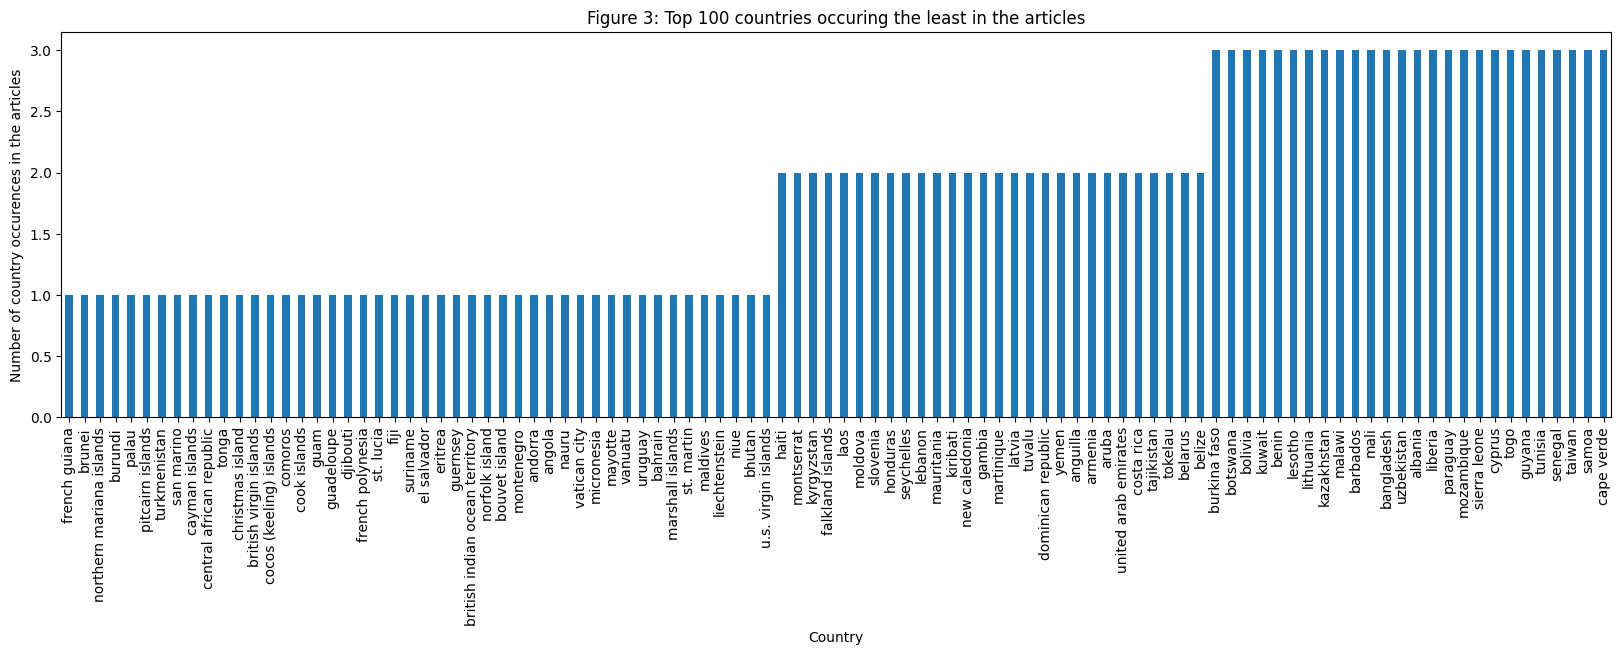

In [32]:
refined_data.groupby("Top_1_name").size().sort_values(ascending=True).head(100).plot(kind="bar", figsize=(20, 5))

plt.ylabel("Number of country occurences in the articles")
plt.xlabel("Country")

plt.title("Figure 3: Top 100 countries occuring the least in the articles")
plt.show()

On this plot we see that the countries that occur the least in the Wikipedia data are small countries or islands that have less influence on world dymanics nowadays. 

## 1.2 Are articles about some countries on average more connected than others


We will see what the relations are between the country of an article compared to the countries it is connected to in it's outgoing links. 

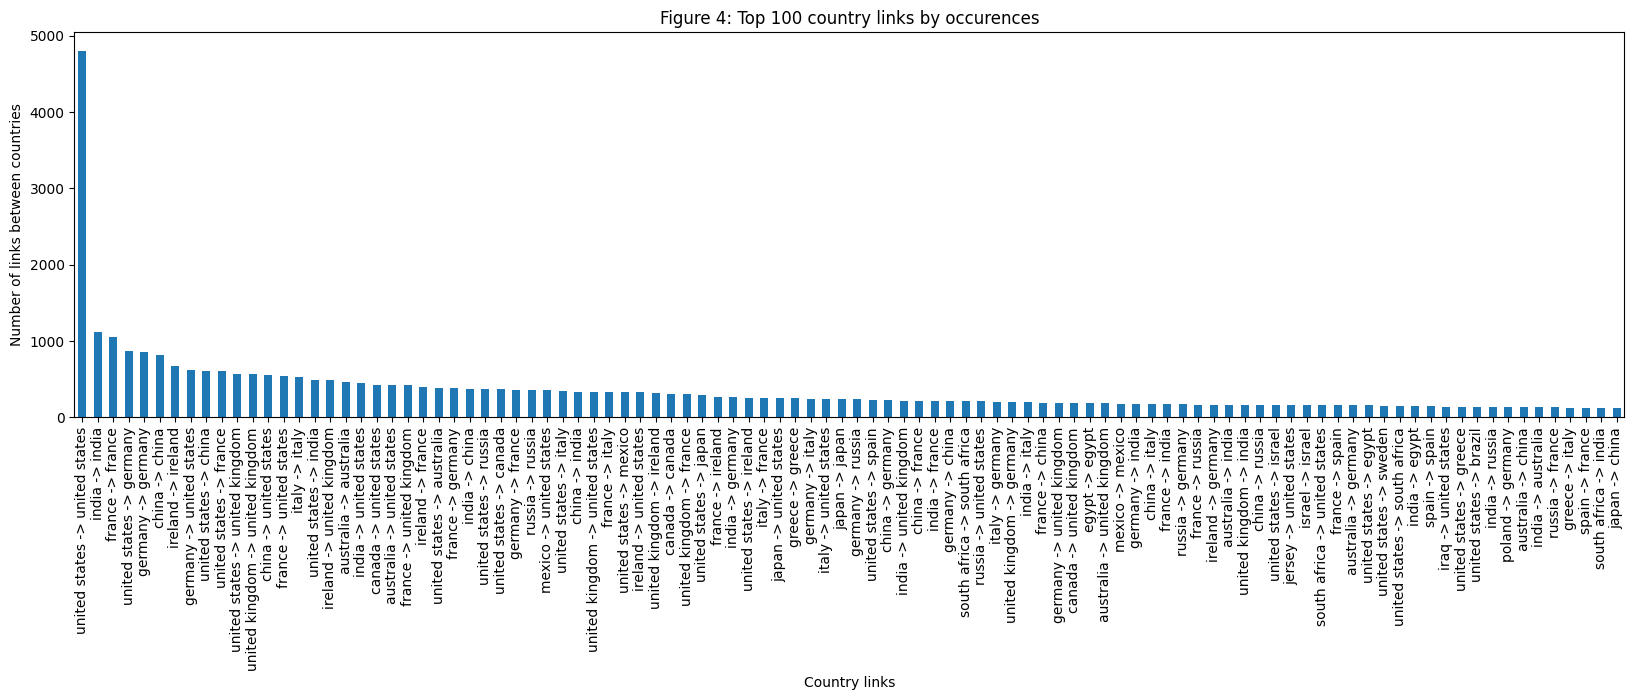

In [33]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
plot_country_to_country(country_clicks)

It can be seen that articles of one country are always strongly interconnected. In the sense that once the user is inside articles assigned to a specific country, they have larger chances to stay in articles of the sam country by clicking on links to navigate to other articles. This can be observed by the fact that there are many connections of the form "france" -> "france" that are occuring and have higher counts than connections "france" -> "other country"

# 2. Are there cultural biases in the way players play Wikispeedia?


Above we have focused on the distribution of different countries in the Wikipedia data. Now we will have a closer look into the **Wikispeedia data**! 

The data that will be used for the rest of this notebook can be created by uncommenting the cell below (Note: we already ran it for you so the data in ```data/country_clicks_links.csv``` can be directly loaded!)

In [34]:
#!python articles_clicks_links.py

The dataframe containsthe following columns: 

- **Top_1_name** = name of the country that occurs the most in the article
- **Top_2_name** = name of the country that occurs the second most in the article
- **Top_1_count** = number of times that the Top1 country occurs
- **Top_2_count** = number of times that the Top2 country occurs
- **click_count** = number of times the article occurs in the clicking paths of the Wikispeedia game
- **num_links_in** = number of articles that lead to article of interest 
- **name_links_in** = name of the artciles that lead to article of interest
- **num_links_out** = number of links in the article of interest, leading out of the article
- **name_links_out** = name of the articles that are references by the article of interest 

Each row is an article. 

In [35]:
df_country_clicks_links = pd.read_csv('data/country_clicks_links.csv', index_col=0)
df_country_clicks_links.shape

(4604, 9)

## 2.1 What articles are most often clicked on? How does this relate to the country of the article?

The first thing to do is to look at the *usage* of articles by players in the Wikispeedia game, so the number of times an article is clicked (e.g. number of article occurrences in the merged finished and unfinished paths).

In [36]:
df_country_clicks_links_sorted = df_country_clicks_links.sort_values(by='click_count', ascending=False)

### Most used articles 

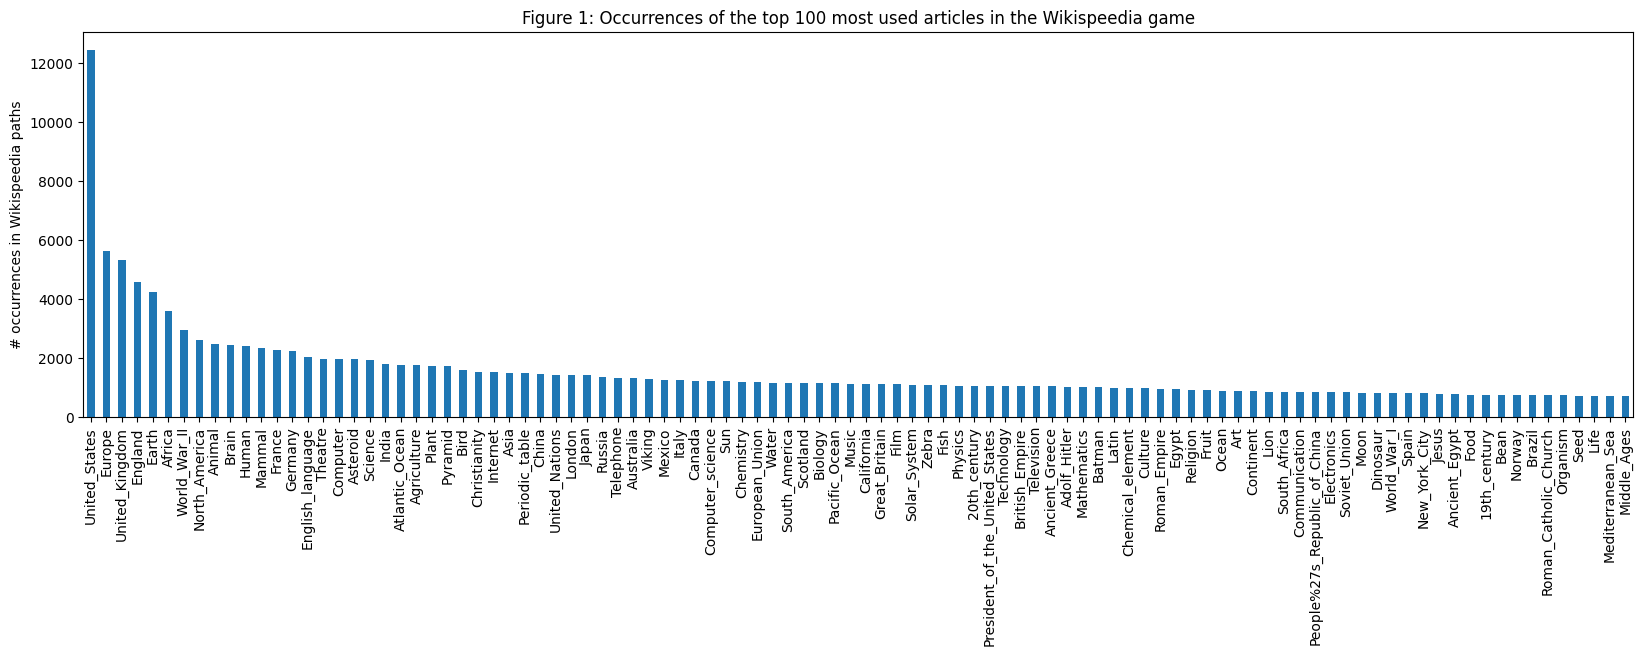

In [37]:
# plot the most used articles 
df_country_clicks_links_sorted['click_count'].head(100).plot(kind='bar', stacked=True, figsize=(20, 5))

plt.xticks(ticks=range(len(df_country_clicks_links_sorted.head(100))), labels=df_country_clicks_links_sorted.index.tolist()[0:100], fontsize=10)
plt.ylabel('# occurrences in Wikispeedia paths')

plt.title("Figure 1: Occurrences of the top 100 most used articles in the Wikispeedia game")
plt.show()

We see that the most used article is United_States. This article is much more used that all other articles which have roughly the same click number. This is evidence showing that United_States is a "hub" article. 

**Which countries are represented within the most used articles?**

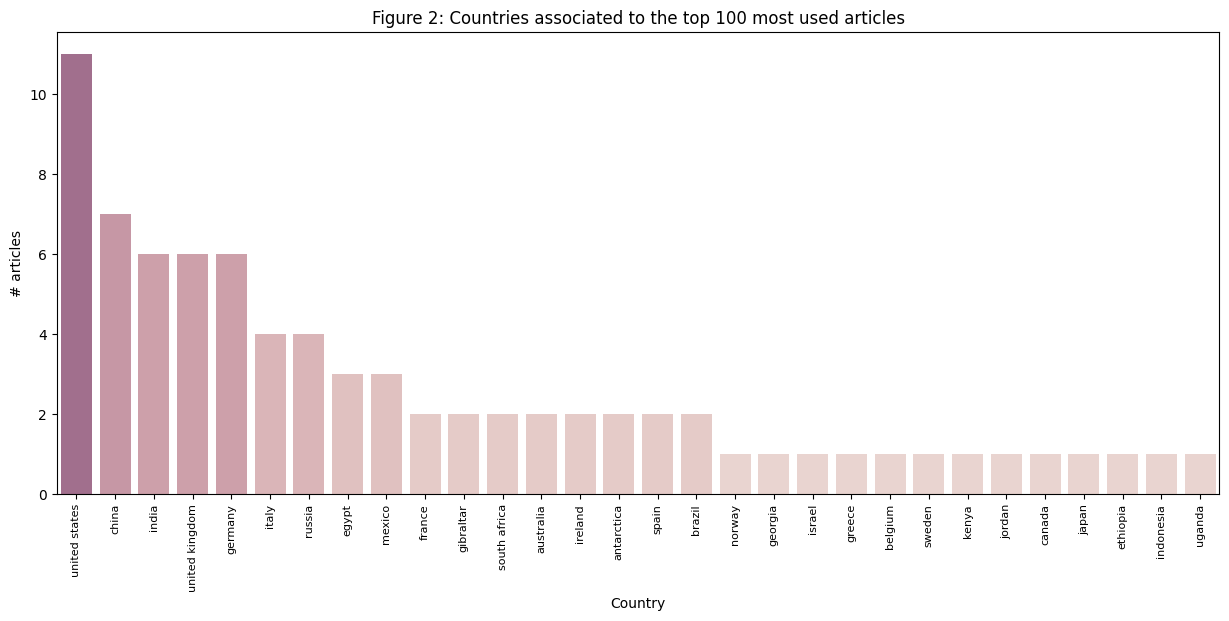

In [38]:
df_top_1_article_count_per_country = pd.DataFrame(df_country_clicks_links_sorted['Top_1_name'].head(100).value_counts(dropna=False))

plt.figure(figsize=(15, 6))
sns.barplot(x=df_top_1_article_count_per_country.index, y=df_top_1_article_count_per_country['count'], hue=df_top_1_article_count_per_country['count'], legend=False)
plt.xticks(fontsize=8, rotation=90)

plt.ylabel('# articles')
plt.xlabel("Country")
plt.title("Figure 2: Countries associated to the top 100 most used articles")

plt.show()

We see that the top 100 most used articles belong mostly to the United States, United Kingdom, China, India and Germany. This relates to the most occuring countries (Figure 2 in part 1.1)

In [39]:
df_top_1_article_count_per_country[df_top_1_article_count_per_country.index.isna()]

,count
Top_1_name,
NaN,21


Among the Top 100 articles, 21 are belonging to no country. 

We see that the United States are the most represented in the 100 most used articles (11/100 most used articles belong to USA). But, the articles associated to this country have a huge variance in click count. Indeed, the article United_states has 12449 while New_York_City has 793. This strong differences in click counts explains why the United States appear as the most clicked country in the plot in Figure 4

**Which countries are most clicked?**

In [40]:
# count number of clicks per country
country_clicks = df_country_clicks_links.groupby('Top_1_name')['click_count'].sum().reset_index()
sorted_country_clicks = country_clicks.sort_values(by='click_count', ascending=False)

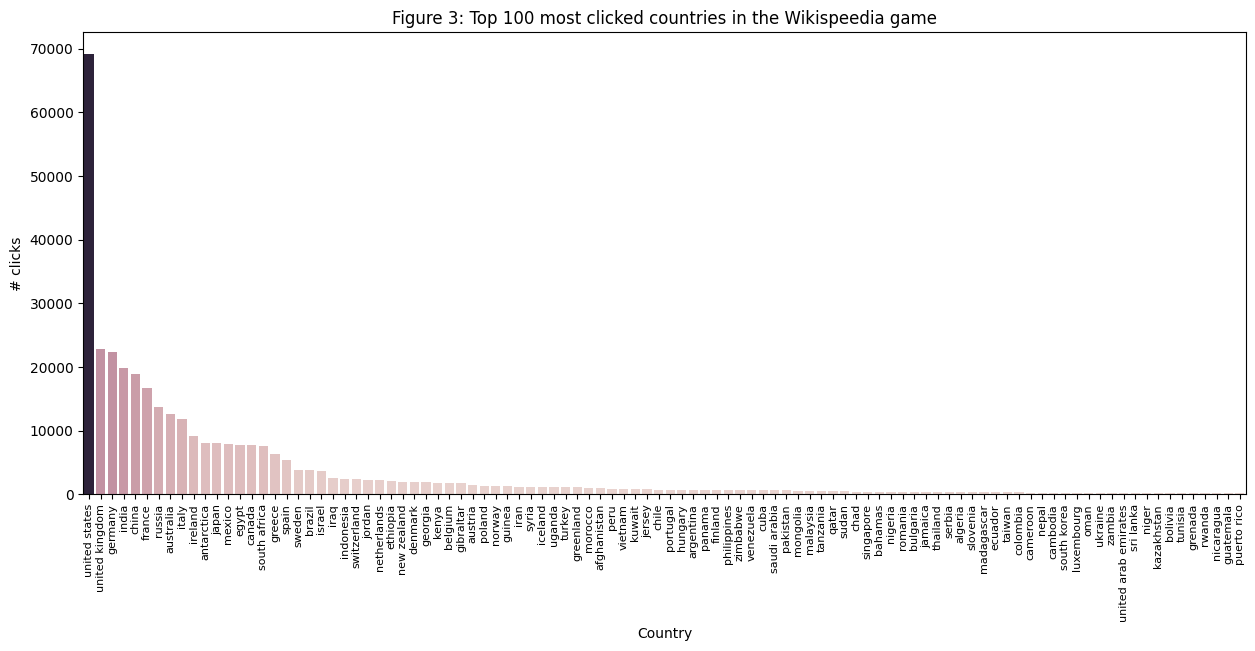

In [41]:
plt.figure(figsize=(15, 6))
sns.barplot(x="Top_1_name", y="click_count", hue='click_count', data=sorted_country_clicks.head(100), legend=False)

plt.xticks(ticks=range(len(sorted_country_clicks.head(100))), labels=sorted_country_clicks['Top_1_name'].head(100), fontsize=8, rotation=90)
plt.ylabel('# clicks')
plt.xlabel("Country")
plt.title("Figure 3: Top 100 most clicked countries in the Wikispeedia game")
plt.show()

### Least used articles

In [42]:
# find articles that are never clicked on
never_used_articles = df_country_clicks_links[df_country_clicks_links['click_count'] == 0]
print(f'there are {round(len(never_used_articles)/len(df_country_clicks_links) * 100, 2)}% of articles that are never clicked on in the game')

there are 9.17% of articles that are never clicked on in the game


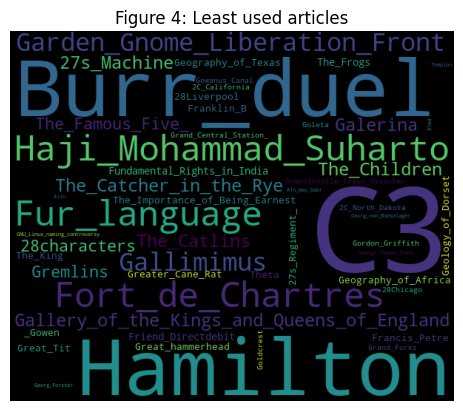

In [43]:
# Generate the word cloud for the least used articles
unique_string_least = (" ").join(list(df_country_clicks_links_sorted.index.tolist()[-40:]))
wordcloud_least = WordCloud(width=600, height=500).generate(unique_string_least)

# Plot the word cloud for the least used articles
plt.imshow(wordcloud_least)
plt.title("Figure 4: Least used articles")
plt.axis("off")
plt.show()

The least occurring articles are never clicked and are on strange topics that are not very well known to common knowledge. 

**Which countries are most represented within the least used articles?**

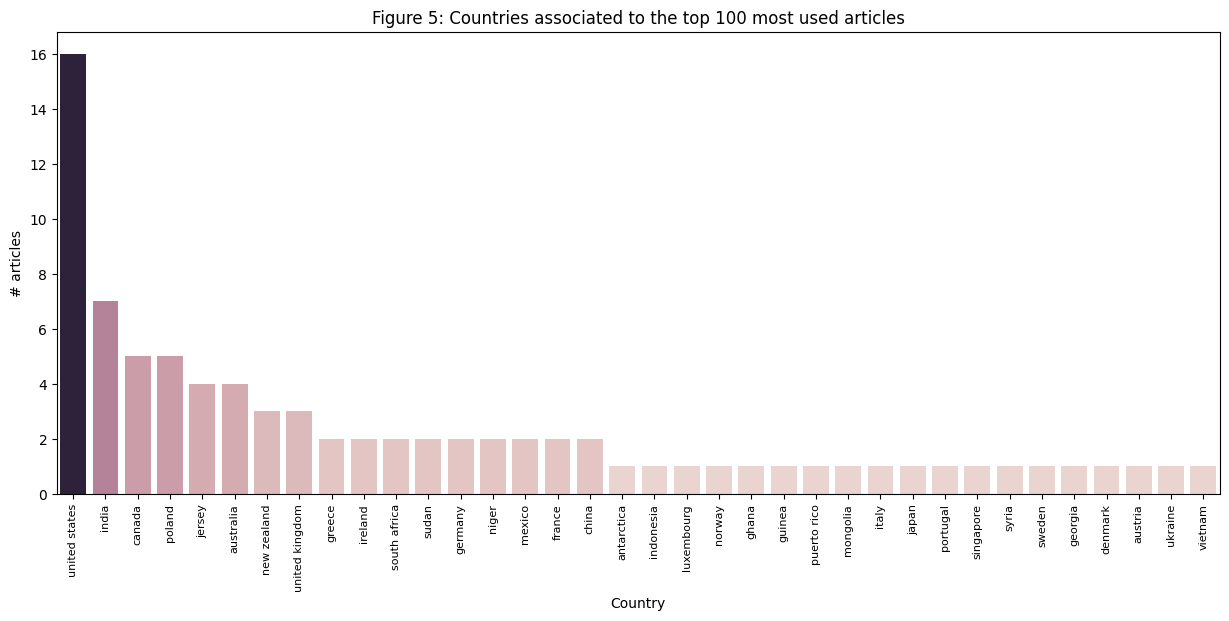

In [44]:
df_least_article_count_per_country = pd.DataFrame(df_country_clicks_links_sorted['Top_1_name'].tail(100).value_counts(dropna=False))

plt.figure(figsize=(15, 6))
sns.barplot(x=df_least_article_count_per_country.index, y=df_least_article_count_per_country['count'], hue=df_least_article_count_per_country['count'], legend=False)
plt.xticks(fontsize=8, rotation=90)

plt.ylabel('# articles')
plt.xlabel("Country")
plt.title("Figure 5: Countries associated to the top 100 most used articles")

plt.show()

In [45]:
df_least_article_count_per_country[df_least_article_count_per_country.index.isna()]

,count
Top_1_name,
NaN,16


Among the 100 least used articles, 16 are belonging to no country. 

We see that also among the 100 least used articles, the United States are the leading country, again by far. This can be explained by the fact that there are far more articles in general that are associated to the United States. So this country dominates the most and the least used articles. 

**What are the least clicked countries?**

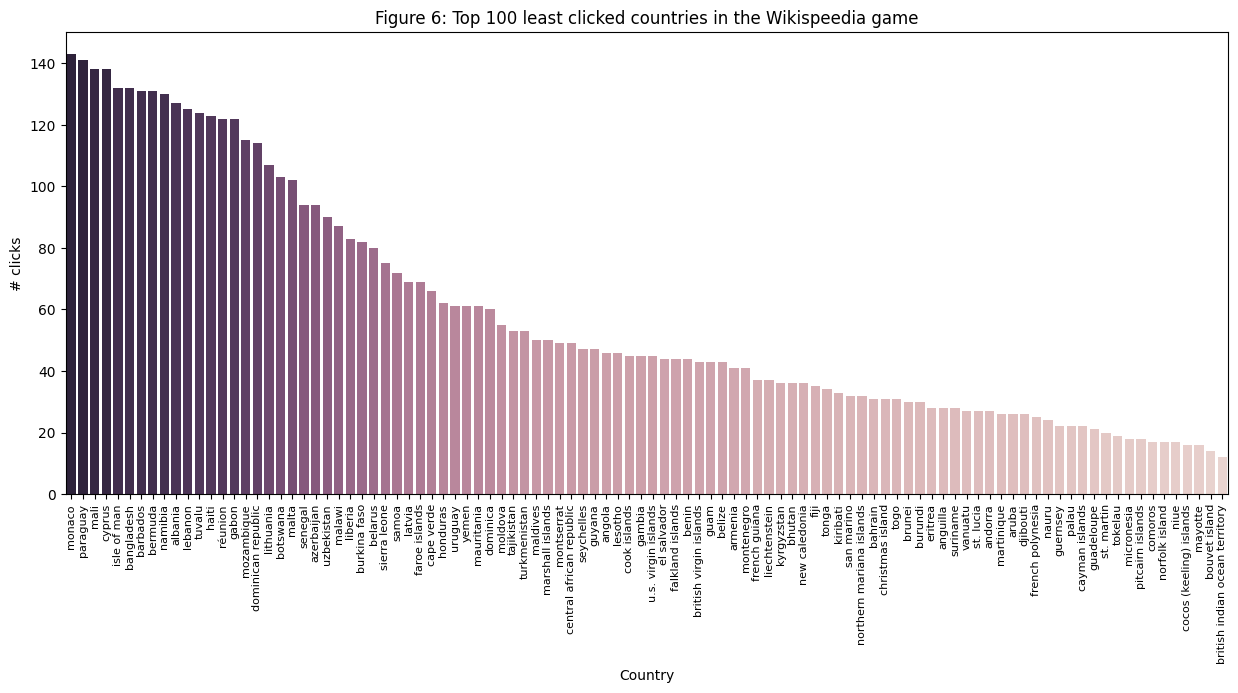

In [46]:
plt.figure(figsize=(15, 6))
sns.barplot(x="Top_1_name", y="click_count", hue='click_count', data=sorted_country_clicks.tail(100), legend=False)

plt.xticks(ticks=range(len(sorted_country_clicks.tail(100))), labels=sorted_country_clicks['Top_1_name'].tail(100), fontsize=8, rotation=90)
plt.ylabel('# clicks')
plt.xlabel("Country")
plt.title("Figure 6: Top 100 least clicked countries in the Wikispeedia game")
plt.show()

### Caveat & scaling: a more advanced approach to investigate article usage

The plots above are the result of a very naive analysis. We simply counted the number of times that and article/country is clicked. But we have shown in part 1 that the distribution of countries in the Wikipedia data is not at all uniform. There are at least 3 times more articles that are associated to the United States than articles associated to any other country. It is thus logical that people click more on countries that are more present. This does not direclty show a bias of the players towards certain countries but simply shows that the Wikipedia graph is itself biased towards some countries and players simply navigate through this biases graph. 

In order to investigate the player's biases towards countries in their clicking behavior, we have to scale the number of clicks per country by the number of occurrences of those countries in the Wikipedia data. 

In [47]:
# scale the number of clicks by the number of occurrences of the country
top_1_counts = df_country_clicks_links['Top_1_name'].value_counts()
country_clicks['occurrences'] = country_clicks['Top_1_name'].map(top_1_counts)
country_clicks["scaled_click_count"] = country_clicks["click_count"] / country_clicks["occurrences"]
sorted_country_clicks = country_clicks.sort_values(by='click_count', ascending=False)

**Which countries are most clicked after scaling?**

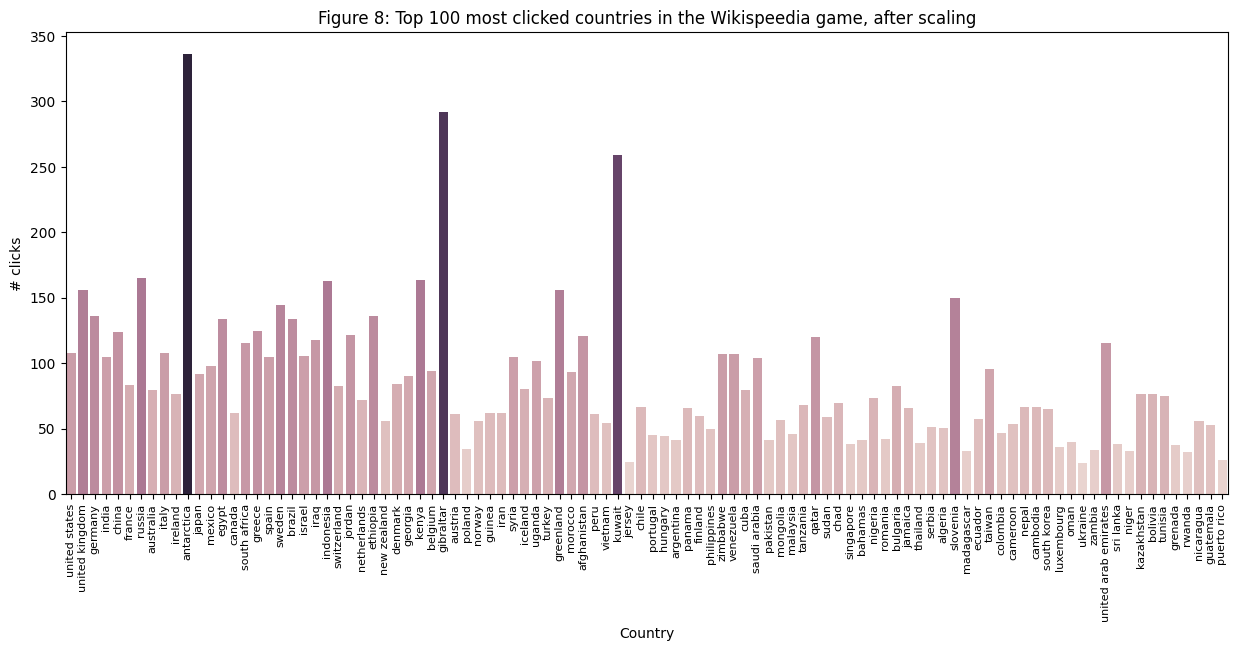

In [48]:
plt.figure(figsize=(15, 6))
sns.barplot(x="Top_1_name", y="scaled_click_count", hue='scaled_click_count', data=sorted_country_clicks.head(100), legend=False)

plt.xticks(ticks=range(len(sorted_country_clicks.head(100))), labels=sorted_country_clicks['Top_1_name'].head(100), fontsize=8, rotation=90)
plt.ylabel('# clicks')
plt.xlabel("Country")
plt.title("Figure 8: Top 100 most clicked countries in the Wikispeedia game, after scaling")
plt.show()

We see that after scaling, the number of clicks on the United States dramatically decreases. The 3 countries that are most clicked on are now Antarctica, Gibraltar and Kuwait. 

**Which countries are least clicked after scaling?**

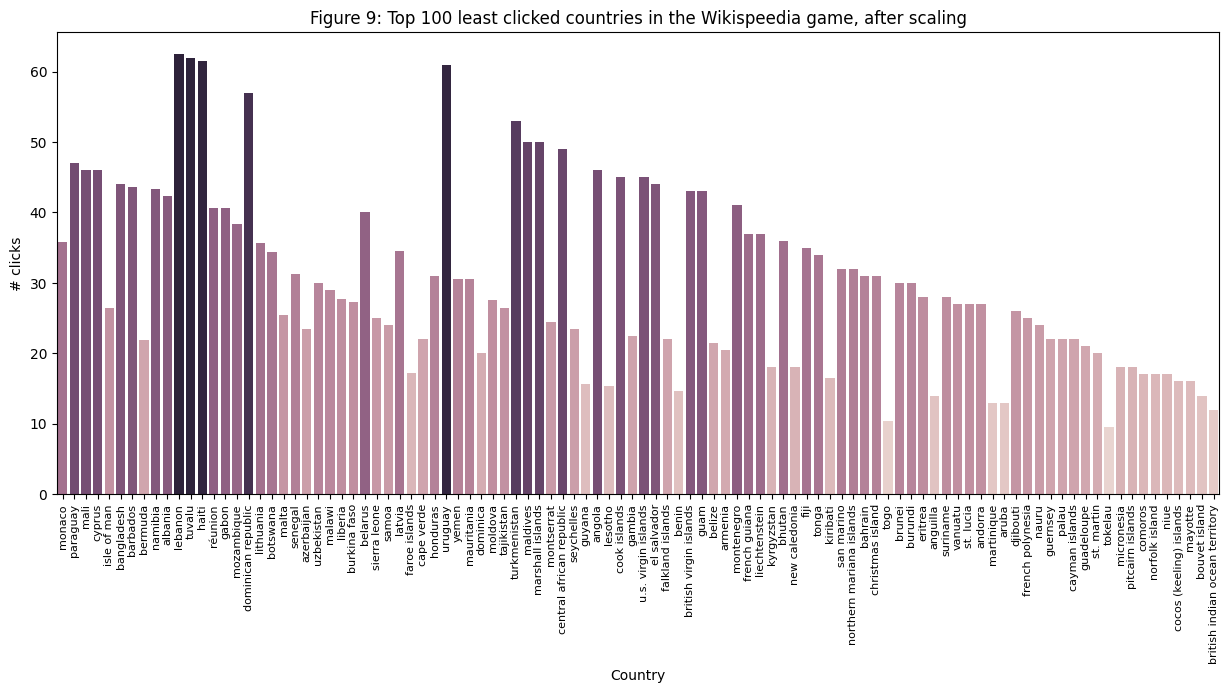

In [49]:
plt.figure(figsize=(15, 6))
sns.barplot(x="Top_1_name", y="scaled_click_count", hue='scaled_click_count', data=sorted_country_clicks.tail(100), legend=False)

plt.xticks(ticks=range(len(sorted_country_clicks.tail(100))), labels=sorted_country_clicks['Top_1_name'].tail(100), fontsize=8, rotation=90)
plt.ylabel('# clicks')
plt.xlabel("Country")
plt.title("Figure 9: Top 100 least clicked countries in the Wikispeedia game, after scaling")
plt.show()

The distribution of the least clicked countries after scaling does not change so drastically. 

## 2.2 What paths do Wikispeedia players most follow? Are there "highway paths" that are very often used? Can this be linked to a cultural bias?


## 2.3 What articles are most likely to cause a player to stop the game? What makes those articles "dead ends"? What does this have to do with the country of these articles?


# 3. How can we explain the players' biases?


## 3.1. What is the distribution of countries among start and target articles for the Wikispeedia games? If it is not balanced, could this be an explanation?

### Analysis of the countries relations between the start and the end of finished paths.

In [3]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].fillna("[]")
country_clicks["num_links_in"] = country_clicks["num_links_in"].fillna(0)
country_clicks["num_links_out"] = country_clicks["num_links_out"].fillna(0)
country_clicks["name_links_out"] = country_clicks["name_links_out"].apply(literal_eval)

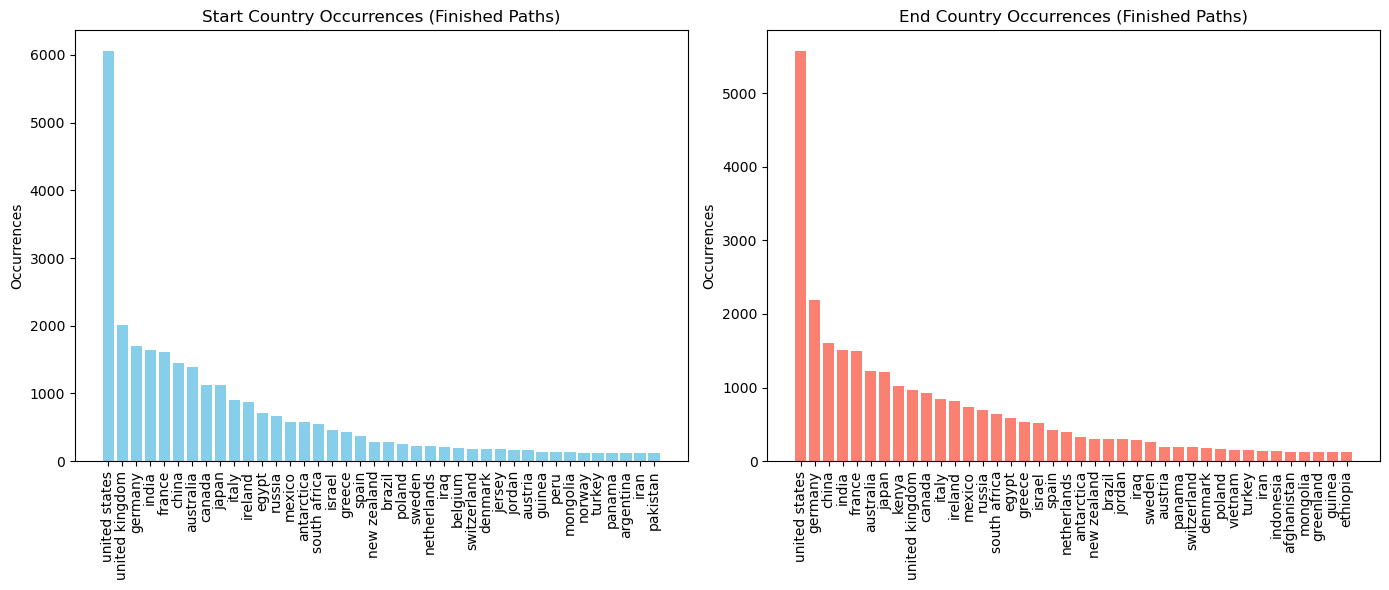

In [16]:
finished_paths = load_path_finished_dataframe()
unfinished_paths = load_path_unfinished_distance_dataframe()

finished_paths["path"] = finished_paths["path"].str.split(";")
unfinished_paths["path"] = unfinished_paths["path"].str.split(";")

paths_to_country(finished_paths, country_clicks, finished=True)
    

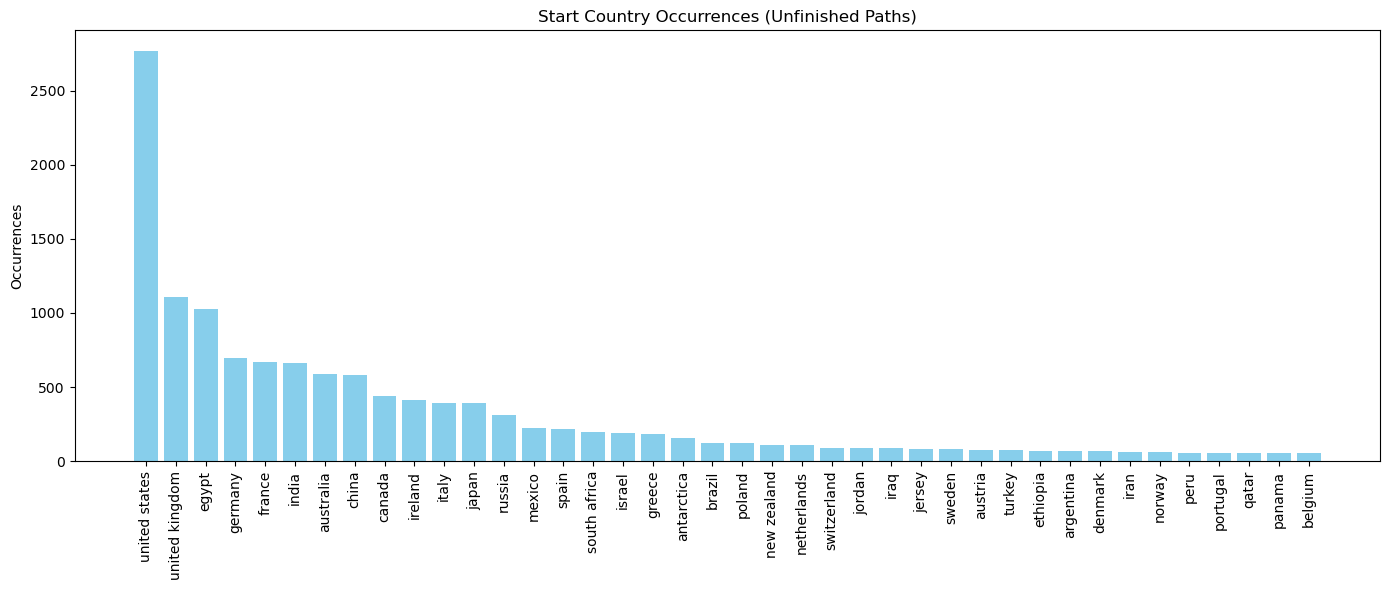

In [14]:
paths_to_country(unfinished_paths, country_clicks, finished=False)


We see that for finished or unfinished path the trend is that articles related to the United States are mostly "selected" as start articles for players. This implies that it counts as a click in the clicks_count statistics and implicitely creates a bias towards some countires even before the game has started. This can be explained by the fact that  start and end articles for a game are randomly selected which implies that that they will overrepresent the countries having more articles and underrepresent articles related to countries with few articles.

An ideal game for our experimental setup would be to have the same number of chances to have an article from the USA's as start than an article from every other country.

## 3.2. Does it simply derive from the fact that the Wikipedia graph is already biased in itself? (Page rank)

#### Articles country to outgoing links countries

## 3.3. Can we explain the variance in player's click counts with the number of links leading in and out of article?

### Statistical analysis trying to estimate the number of clicks an article gets

The first approach is based on the fact that we observed that a lot of articles are classified into 2 predominant countries categories. We thus thought that the country category could have an impact on the number of clicks an article is getting. 
We used an ordinary least squares solver in order to describe this data and tried to predict : 
```click_count ~ num_links_in + num_links_out + C(Top_1_name)```
The number of incoming/outgoing links can also be seen as a useful feature in order to predict the number of clicks an article recieves so this is why there are also included. 
In this case neither num_links_in, num_links_out or click_count were normalized since it is more intuitive to have coefficients in terms of clicks than in term of probabilities. In case the outputs need to be normalized, uncomment the following lines

In [50]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
# country_clicks["click_count"] = country_clicks["click_count"] / country_clicks["click_count"].sum()
# country_clicks["num_links_in"] = (country_clicks["num_links_in"] - country_clicks["num_links_in"].mean()) / country_clicks["num_links_in"].std()
# country_clicks["num_links_out"] = (country_clicks["num_links_out"] - country_clicks["num_links_out"].mean()) / country_clicks["num_links_out"].std()

In [51]:
mod = smf.ols(formula='click_count ~ num_links_in + num_links_out + C(Top_1_name)', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.650
Method:                 Least Squares   F-statistic:                     29.99
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:33:44   Log-Likelihood:                -22346.
No. Observations:                3330   AIC:                         4.512e+04
Df Residuals:                    3116   BIC:                         4.643e+04
Df Model:                         213                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

By analysing the coefficients we see that all p-values of country categories are larger than the alpha-level of 5% (except for antartica for which p-value = 0.003 < 0.05), so we can reject the hypothesis that the countries have a meaningful impact on the number of clicks an article recieves at a significant level. ```Antarctica``` was found to be a significant variable to estimate the number of clicks that an article might get. The coefficient of this variable is 248, meaning that according to the regression, if an article is related to the country of Antarctica, it has 248 times for changes to be clicks. This is very suprising! And might arise from the fact that articles such are 'Earth' (which has a huge amount of clicks: 4216), are associated to Antarctica. Those articles might drive the association between the click count and the variable Antarctica!

Note: The [2] warning tells us that we have a problem of multicollinearity which means that multiple of our independent variables are likely correlated. This can induce misleading conclusions. Below we go to a simpler model resolving this problem. We also have a very stron AIC value wich is due to the fact that we have many parameters in our model (all countries + num_links_in + num_links_out)

Given the results another variable we can't reject at a significant level of 5% is the ```num_links_in``` (p-value = 0 because so small that it is approximated by 0). We will thus further analyse this with a simpler model :  
```click_count ~ num_links_in```

In [52]:
mod = smf.ols(formula='click_count ~ num_links_in', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     7054.
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:33:44   Log-Likelihood:                -27772.
No. Observations:                4135   AIC:                         5.555e+04
Df Residuals:                    4133   BIC:                         5.556e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.5745      3.399     -2.523   

In this case it can be seen that the both the intercept and the num_links_in coefficients are significant at 85% and are thus significant in order to predict the number of clicks an articles recieves. This means that the number of incoming links is related to the number of clicks an article has and moreover each incoming link increases the chance of an article to be clicked by nearly 4. 

We will provide a last analysis trying to see if the number of outgoing links are significant to the number of clicks an article recieves. 
The formula used for this is : ```click_count ~ num_links_in * num_links_out``` so that the cross term is also present.

In [53]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='click_count ~ num_links_in * num_links_out', data=country_clicks)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            click_count   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     4282.
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:33:44   Log-Likelihood:                -26870.
No. Observations:                4129   AIC:                         5.375e+04
Df Residuals:                    4125   BIC:                         5.377e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

The results suggest that the number of incoming and outgoing links, as well as the interaction between them, significantly contribute to predicting the click count on an article. Specifically:

Number of Incoming Links (num_links_in): Each additional incoming link is associated with an increase of approximately 1.53 clicks on average (coefficient: 1.53). This positive coefficient implies that the more links pointing to an article, the higher its visibility and the potential clicks it receives. This effect is statistically significant with a very low p-value (<0.001).

Number of Outgoing Links (num_links_out): Each outgoing link reduces the click count by about 0.86 clicks (coefficient: -0.86), suggesting that articles with more outgoing links may divert readers attention away, leading to fewer clicks. This negative effect is also statistically significant (p < 0.001).

Interaction between Incoming and Outgoing Links (num_links_in:num_links_out): The positive interaction term (coefficient: 0.021) indicates that articles with both high incoming and outgoing links experience a slightly amplified effect on click count. This means that for articles with many incoming links, the negative effect of outgoing links is somewhat mitigated. This subtle effect is also significant (p < 0.001).

Overall Model Fit
R-squared: The R-squared value of 0.758 suggests that approximately 75.8% of the variance in click counts is explained by this model, which indicates a good fit.
F-statistic: The high F-statistic (~5000) with a p-value near zero confirms that the model is statistically significant overall.

It could be that certain articles are clicked more often simply because they contain more links and this information might be intuitively known by the players of the Wikispeedia game which could explain way they tend to click on those "link hub" articles. It could also be that the articles that are most clicked are those that are most cited in other articles. This would mean that players have higher chances to encounter those articles which could explain the higher click count. 

To investigate those 2 hypotheses, we will look at the correlations between the number of clicks and the number of links in and out of articles. 

In [54]:
country_clicks = pd.read_csv("data/country_clicks_links.csv", index_col=0)
country_clicks[['num_links_in', 'num_links_out','click_count']].corr(method="spearman")

,num_links_in,num_links_out,click_count
num_links_in,1.000000,0.587972,0.781284
num_links_out,0.587972,1.000000,0.488208
click_count,0.781284,0.488208,1.000000


Indeed, we see that there is a strong relationship between the number of links into the article and the click count of that article (spearman correlation coefficient of 0.78) showing again that the number of links leading to an article is a good predictor for the number of clicks that this article will receive. 

To have a visual representation of the relationships between the clicks and the number of links in and out for each article we plot below three scatter plots. On top of each plot we display the regression line found by the regplot method of the seaborn package. We see that the coefficients are roughly similar than those displayed in the tables above, confirming our hypothesis. The small variations in coefficients can come from the fact that the regplot function discards outliers in the regression. 

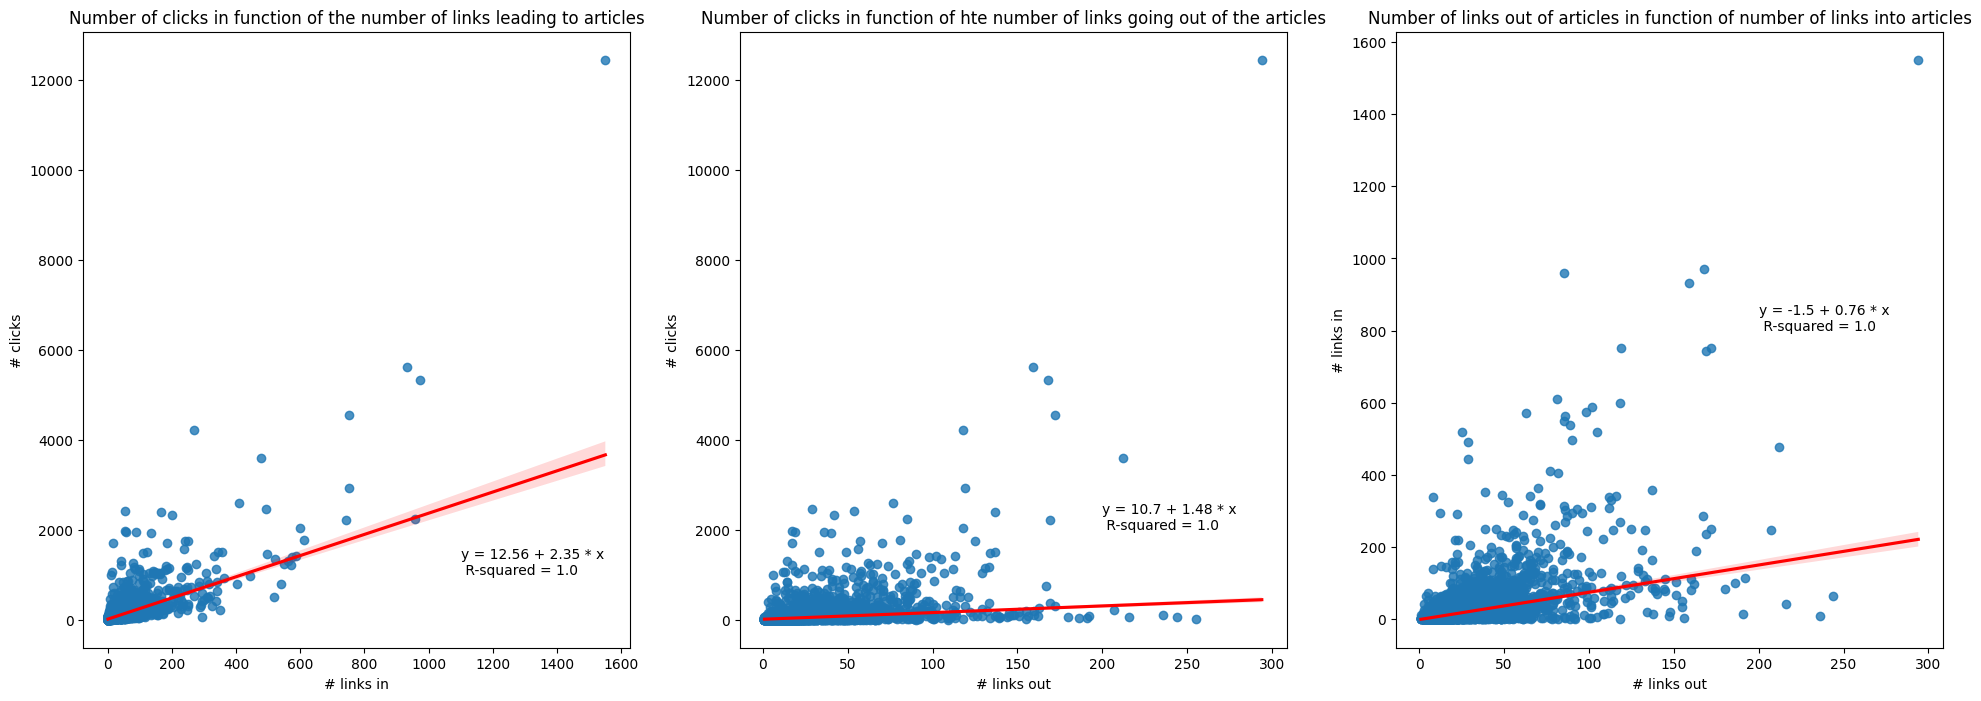

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

plot_regression_clicks_links(country_clicks, 'num_links_in', 'click_count', axes[0], [1100, 1000], "# links in", "# clicks", "Number of clicks in function of the number of links leading to articles")
plot_regression_clicks_links(country_clicks, 'num_links_out', 'click_count', axes[1], [200, 2000], "# links out", "# clicks", "Number of clicks in function of hte number of links going out of the articles")
plot_regression_clicks_links(country_clicks, 'num_links_out', 'num_links_in', axes[2], [200, 800], "# links out", "# links in", "Number of links out of articles in function of number of links into articles")

## 3.4. Is there something inherent to the way players play the game?


Write a general conclusion of all our findings on the biases of the graph and then the biases intrinsic to the players.